<a href="https://colab.research.google.com/github/lmontaldo/tesis2023/blob/main/Preprocesamiento_de_las_series_temporales_28_febrero_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%%capture
#! pip install darts

# Preprocesamiento y transformaciones preliminares de las series temporales


In [2]:
from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [46]:
%%capture
! pip install arch

In [353]:
import time
t_start1 = time.perf_counter()
%matplotlib inline
from arch.unitroot import ADF
## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce
import statsmodels.api as sm 
from scipy.stats import normaltest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
import time
t_start1 = time.perf_counter()
import seaborn as sns
%matplotlib inline
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce
import statsmodels.api as sm 
from scipy.stats import normaltest
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
import scipy
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [325]:
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
import sys
import os

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/MyDrive/MAESTRIA/tesis2022/tesis/Clases_y_documentos
sys.path.append('/content/drive/MyDrive/MAESTRIA/tesis2022/tesis/Clases_y_documentos')

[Errno 2] No such file or directory: '/content/drive/MyDrive/MAESTRIA/tesis2022/tesis/Clases_y_documentos'
/content


## Importación de paquetes y acceso a los datos en el drive

In [10]:
# opening worksheet
sh = gc.open('Datos')

In [11]:
# Selecting a Worksheet
ws_ipc = sh.worksheet("ipc")
ws_usd = sh.worksheet("fmi_2022_external") # hasta 2017M6
ws_cl = sh.worksheet("clases")
ws_descrip=sh.worksheet("Ext_Description")
ws_ipc_grl=sh.worksheet("ipc univariado")

In [12]:
# all values to df
df_ipc = pd.DataFrame(ws_ipc.get_all_records()) 
df_usd = pd.DataFrame(ws_usd.get_all_records()) # df Commodities
df_cl=pd.DataFrame(ws_cl.get_all_records()) # df clases ipc
df_ext=pd.DataFrame(ws_descrip.get_all_records()) # df food variables in external
df_gral=pd.DataFrame(ws_ipc_grl.get_all_records())

## IPC general

In [321]:
df_gral[['month','year']]=df_gral.fecha.str.split('-',expand=True)
df_gral['year']=str('20')+df_gral['year']
months = ['ene','feb','mar','abr','may','jun','jul','ago','set','oct','nov','dic']
d = dict(zip(months, np.arange(1, 13)))
df_gral['month']=df_gral['month'].replace(d, regex=True)
df_gral['ymd'] = pd.to_datetime(df_gral[['year', 'month']].assign(day=1), format='%d/%b/%Y')

In [373]:
ipc_gral=df_gral.loc[:,["ymd","indice"]]

In [324]:
import plotly.express as px
fig = px.line(ipc_gral, x='ymd', y="indice", title='Evolución del IPC general')
fig.show()

In [375]:
ipc_gral_idx=ipc_gral.set_index("ymd")
log_ipc_gral_idx =ipc_gral_idx.apply(lambda x : np.log(x))

In [376]:
ipc_gral_idx=ipc_gral.set_index('ymd')
decompose_result=seasonal_decompose(log_ipc_gral_idx, model='additive', period=12)

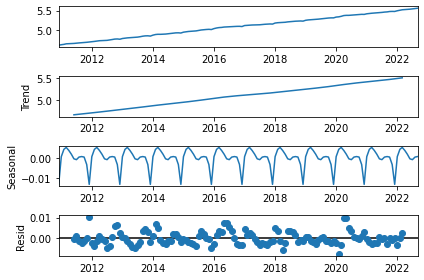

In [377]:
decompose_result.plot()
plt.show()

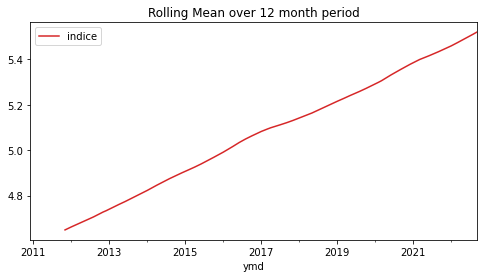

In [379]:
log_ipc_gral_idx.rolling(window = 12).mean().plot(figsize=(8,4), color="tab:red", title="Rolling Mean over 12 month period");

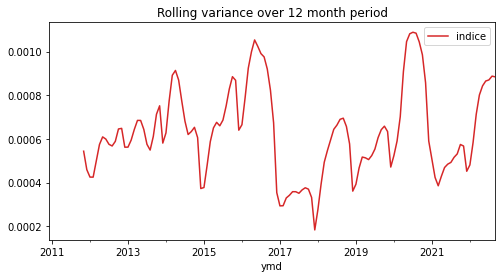

In [380]:
log_ipc_gral_idx.rolling(window = 12).var().plot(figsize=(8,4), color="tab:red", title="Rolling variance over 12 month period");
#low seasonality effect at the beginning which amplifies over time

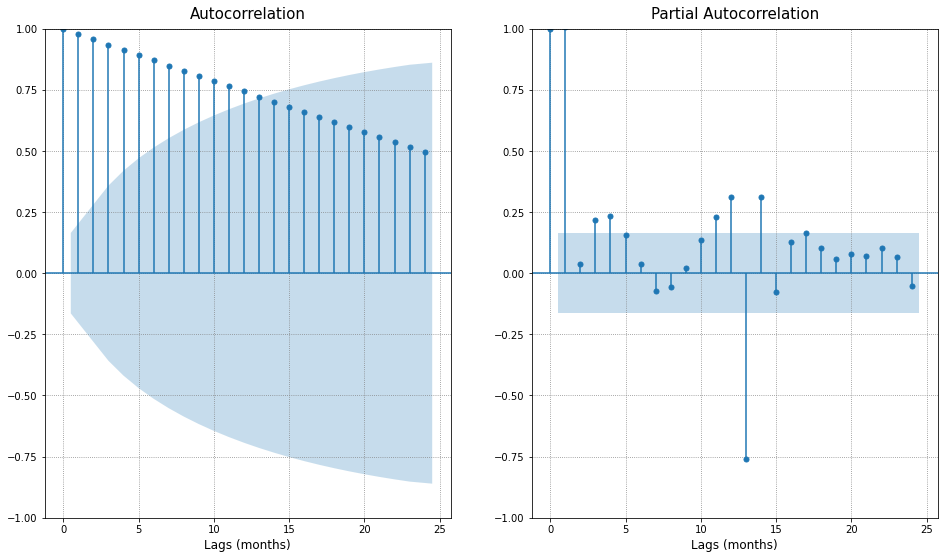

In [381]:
def plot_acf_pacf(df: pd.DataFrame, acf_lags: int, pacf_lags: int) -> None:
    """
    This function plots the Autocorrelation and Partial Autocorrelation lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the order count and dates.
        acf_lags (int): Number of ACF lags
        pacf_lags (int): Number of PACF lags
    Returns: None
    """
    
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), facecolor='w')
    
    # ACF & PACF
    plot_acf(df, ax=ax1, lags=acf_lags)
    plot_pacf(df, ax=ax2, lags=pacf_lags, method="ols-adjusted")#regression of time series on lags with a bias adjustment.
    

    # Labels
    ax1.set_title("Autocorrelation", fontsize=15, pad=10)
    #ax1.set_ylabel("IPC general", fontsize=12)
    ax1.set_xlabel("Lags (months)", fontsize=12)

    ax2.set_title("Partial Autocorrelation", fontsize=15, pad=10)
    #ax2.set_ylabel("IPC general", fontsize=12)
    ax2.set_xlabel("Lags (months)", fontsize=12)
    
    # Legend & Grid
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')

    plt.show()

    
plot_acf_pacf(log_ipc_gral_idx, acf_lags=24, pacf_lags=24)

#### Detrending 

In [383]:
d_ipc_gral_idx=log_ipc_gral_idx.diff().dropna()

### removing seasonal component

In [389]:
def STL_seasonal_adjusted(series):
  """
  1- Uses a STL method: Seasonal-Trend Decomposition Procedure Based on Loess
  * It handles any type of seasonality
  * The user can control the rate of change of the seasonal component
  * It is robust to outliers
  The seasonal argument is set to 7 by default. The larger is the integer, the more ‘smooth’ 
  the seasonal component becomes. This causes less of the variation in the data to be attributed to its seasonal component.
  2- Keeps only the seasonal component (sc) and creates a df with the sc of each IPC component
  3- Removes from original series the seasonal component
  """
  x  = STL(series, robust = False).fit()
  output =  series-x.seasonal
  return pd.Series(output)

In [392]:
stl_d_gral=d_ipc_gral_idx.apply(lambda x: STL_seasonal_adjusted(x))

In [394]:
stl_d_gral_sin_idx=stl_d_gral.reset_index()
stl_d_gral_sin_idx.head()

,ymd,indice
0,2011-01-01,0.010358
1,2011-02-01,0.008438
2,2011-03-01,0.008254
3,2011-04-01,0.005005
4,2011-05-01,0.006959


In [395]:
stl_d_gral
import plotly.express as px
fig = px.line(stl_d_gral_sin_idx, x='ymd', y='indice', title='IPC en primeras diferencias con ajuste estacional')
fig.show()

In [463]:
from arch.unitroot import ADF
adf_c = ADF(stl_d_gral, trend="c", method='aic')
print(adf_c.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.009
P-value                         0.001
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [464]:
reg_res = adf_c.regression
print(reg_res.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     9.556
Date:                Sun, 19 Mar 2023   Prob (F-statistic):           1.34e-13
Time:                        04:46:18   Log-Likelihood:                 615.72
No. Observations:                 127   AIC:                            -1201.
Df Residuals:                     112   BIC:                            -1159.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.9129      0.228     -4.009      0.0

In [456]:
results_as_html = reg_res.summary().tables[1].as_html()
tau_t=pd.read_html(results_as_html, header=0, index_col=0)[0]
tau_tau=tau_t.iloc[0,0]/tau_t.iloc[0,1]
tau_tau

0.017857142857142856

In [465]:
adf_n = ADF(stl_d_gral, trend="nc", method='aic')
print(adf_c.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.009
P-value                         0.001
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [466]:
reg_res_n = adf_n.regression
print(reg_res_n.summary().as_text())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.478
Model:                            OLS   Adj. R-squared (uncentered):              0.419
Method:                 Least Squares   F-statistic:                              8.103
Date:                Sun, 19 Mar 2023   Prob (F-statistic):                    2.48e-11
Time:                        04:47:16   Log-Likelihood:                          611.11
No. Observations:                 128   AIC:                                     -1196.
Df Residuals:                     115   BIC:                                     -1159.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [434]:
from statsmodels.tsa.stattools import adfuller
# Modelo (c) con constante y con tendencia
def adfuller_test_n(series, signif=0.05):
  """
  Augmented Dickey-Fuller unit root test.
  The Augmented Dickey-Fuller test can be used to test for a unit root in 
  a univariate process in the presence of serial correlation.
  series: time series in pd.Series format
  signif: significance level for P-value to reject Null Hypothesis
  Null Hypothesis: The series has a unit root.
  Alternate Hypothesis: The series has no unit root.
  If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary
  If True then No RH_0), else RH_0)
  """
  x = adfuller(series, autolag='AIC',  store=True, regresults=True, regression='c', maxlag=None)# constant
  #output = {'The test statistic': x[0],'p-value': x[1],  'critical values': x[2], f'Reject (signif. level {signif})': 'Stationary' if x[1] < signif else 'Not Stationary' }
  results= {'Rh0':True if x[1] < signif else False} 
  return pd.Series(results)

In [436]:
stl_d_gral.apply(lambda x: adfuller_test_c(x))

,indice
Rh0,True


In [433]:
#x=adfuller(stl_d_gral, autolag='AIC',  store=True, regresults=True, regression='c', maxlag=None)
adfstat, pvalue, critvalues, resstore = adfuller(stl_d_gral, maxlag=None, regression="c", autolag='AIC', store=True)
resstore

In [417]:
from statsmodels.tsa.stattools import kpss
def kpss_constant_legacy(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a trend
  nlags: Indicates the number of lags to be used. 
  nlags=“legacy”, uses int(12 * (n / 100)**(1 / 4)), as outlined in Schwert (1989)
  with “auto” lags are calculated using the data-dependent method of Hobijn et al.(1998)

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
  x = kpss(series, nlags='legacy', regression='c') # “ct” : The data is stationary around a constant

    #using dictionary saves different data types (float, int, boolean)
  output = {'kpss_stat': x[0], 'P-value': x[1], 'lags': x[2], 'Rh0':True if x[1] < signif else False }
  #results= {'Rh0':True if x[1] < signif else False} 
  return pd.Series(output)

In [418]:
stl_d_gral.apply(lambda x: kpss_constant_legacy(x))

,indice
kpss_stat,0.083324
P-value,0.1
lags,14
Rh0,False


In [419]:
def kpss_constant_auto(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a trend
  nlags: Indicates the number of lags to be used. 
  nlags=“legacy”, uses int(12 * (n / 100)**(1 / 4)), as outlined in Schwert (1989)
  with “auto” lags are calculated using the data-dependent method of Hobijn et al.(1998)

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
  x = kpss(series, nlags='auto', regression='c') # “ct” : The data is stationary around a constant

    #using dictionary saves different data types (float, int, boolean)
  output = {'kpss_stat': x[0], 'P-value': x[1], 'lags': x[2], 'Rh0':True if x[1] < signif else False }
  #results= {'Rh0':True if x[1] < signif else False} 
  return pd.Series(output)

In [420]:
stl_d_gral.apply(lambda x: kpss_constant_auto(x))

,indice
kpss_stat,0.102885
P-value,0.1
lags,1
Rh0,False


## Preprocesamiento de los datos de las clases del IPC

In [13]:
# Lista de clases relativas al IPC las 88 componentes
cl=df_cl.drop(['codigo', 'Clases'], axis=1)

In [14]:
# Se filtran de los datos unicamente las filas correspondientes a las clases del IPC
d_ipc=df_ipc.merge(cl, left_on='c_codigo',right_on= 'c_codigo', how='inner')

In [15]:
d_ipc=d_ipc.rename(columns = {'Divisiones, Grupos, Clases, Familias y Productos':'clases'})

In [16]:
# Datos crudos del IPC que van a servir de insumo para el estudio
ipc=d_ipc.drop(['codigo', 'clases'], axis=1)

In [17]:
# Cambio de wide to long
year_list=list(ipc.iloc[:, 0:-1].columns)
clases = pd.melt(ipc, id_vars=['c_codigo'], value_vars=year_list)
clases_ipc=clases.rename({'variable': 'fecha', 'value': 'indice'}, axis=1)

In [18]:
# armo columna de fecha con formato fecha: ymd
clases_ipc[['month','year']]=clases_ipc.fecha.str.split('-',expand=True)

In [19]:
clases_ipc['year']=str('20')+clases_ipc['year']

In [20]:
#clases_ipc.month.unique()
months = ['ene','feb','mar','abr','may','jun','jul','ago','set','oct','nov','dic']
d = dict(zip(months, np.arange(1, 13)))

In [21]:
clases_ipc['month']=clases_ipc['month'].replace(d, regex=True)

In [212]:
clases_ipc['ymd'] = pd.to_datetime(clases_ipc[['year', 'month']].assign(day=1), format='%d/%b/%Y')
clases_ipc.columns

Index(['c_codigo', 'fecha', 'indice', 'month', 'year', 'ymd'], dtype='object')

In [209]:
# se transforman el formato de los datos de long a wide
ipc_wide=pd.pivot(clases_ipc, index=['ymd'], columns = 'c_codigo',values = 'indice')
ipc_wide.columns.name = None

In [211]:
ipc_wide.columns

Index(['c0111', 'c0112', 'c0113', 'c0114', 'c0115', 'c0116', 'c0117', 'c0118',
       'c0119', 'c0121', 'c0122', 'c0211', 'c0212', 'c0213', 'c0220', 'c0312',
       'c0314', 'c0321', 'c0322', 'c0411', 'c0431', 'c0432', 'c0441', 'c0442',
       'c0443', 'c0444', 'c0451', 'c0452', 'c0454', 'c0511', 'c0520', 'c0531',
       'c0533', 'c0540', 'c0551', 'c0552', 'c0561', 'c0562', 'c0611', 'c0613',
       'c0621', 'c0622', 'c0623', 'c0630', 'c0690', 'c0711', 'c0712', 'c0713',
       'c0721', 'c0722', 'c0723', 'c0724', 'c0732', 'c0733', 'c0734', 'c0735',
       'c0736', 'c0810', 'c0820', 'c0830', 'c0911', 'c0912', 'c0913', 'c0914',
       'c0931', 'c0933', 'c0934', 'c0935', 'c0941', 'c0942', 'c0943', 'c0951',
       'c0952', 'c0954', 'c0960', 'c1010', 'c1020', 'c1040', 'c1050', 'c1111',
       'c1112', 'c1120', 'c1211', 'c1213', 'c1232', 'c1252', 'c1254', 'c1270'],
      dtype='object')

In [200]:
 ipc_wide.index.names

FrozenList(['ymd'])

In [25]:
# ipc_wide.columns

In [26]:
# chequeo exitencia de valores nuloes
ipc_wide.isnull().sum().sum()

0

In [27]:
# lista de componentes
componentes=ipc_wide.columns.to_list()

In [28]:
# saco el index para los graficos
ipc_wide_sin_index=ipc_wide.reset_index()

In [29]:
ipc_wide.shape

(135, 88)

### Clases del IPC en Niveles

In [30]:
import plotly.express as px
fig = px.line(ipc_wide_sin_index, x='ymd', y=componentes, title='Clases del IPC en niveles')
fig.show()

Las series de las clases del IPC  mantienen en su mayoría una evidente tendencia al alza, sin embargo la clase  "Transporte de pasajeros por mar y cursos de agua interiores" ($c0734$) se despega del conjunto mayor con un comportamiento distinto al resto con valores muy por encima al resto.
Por otro lado, la serie "Equipo telefónico y de facsímile" ($c0820$), presenta una tendencia constante y con valores del índice por debajo del resto.

Text(0.5, 0.98, 'Clases del IPC en niveles')

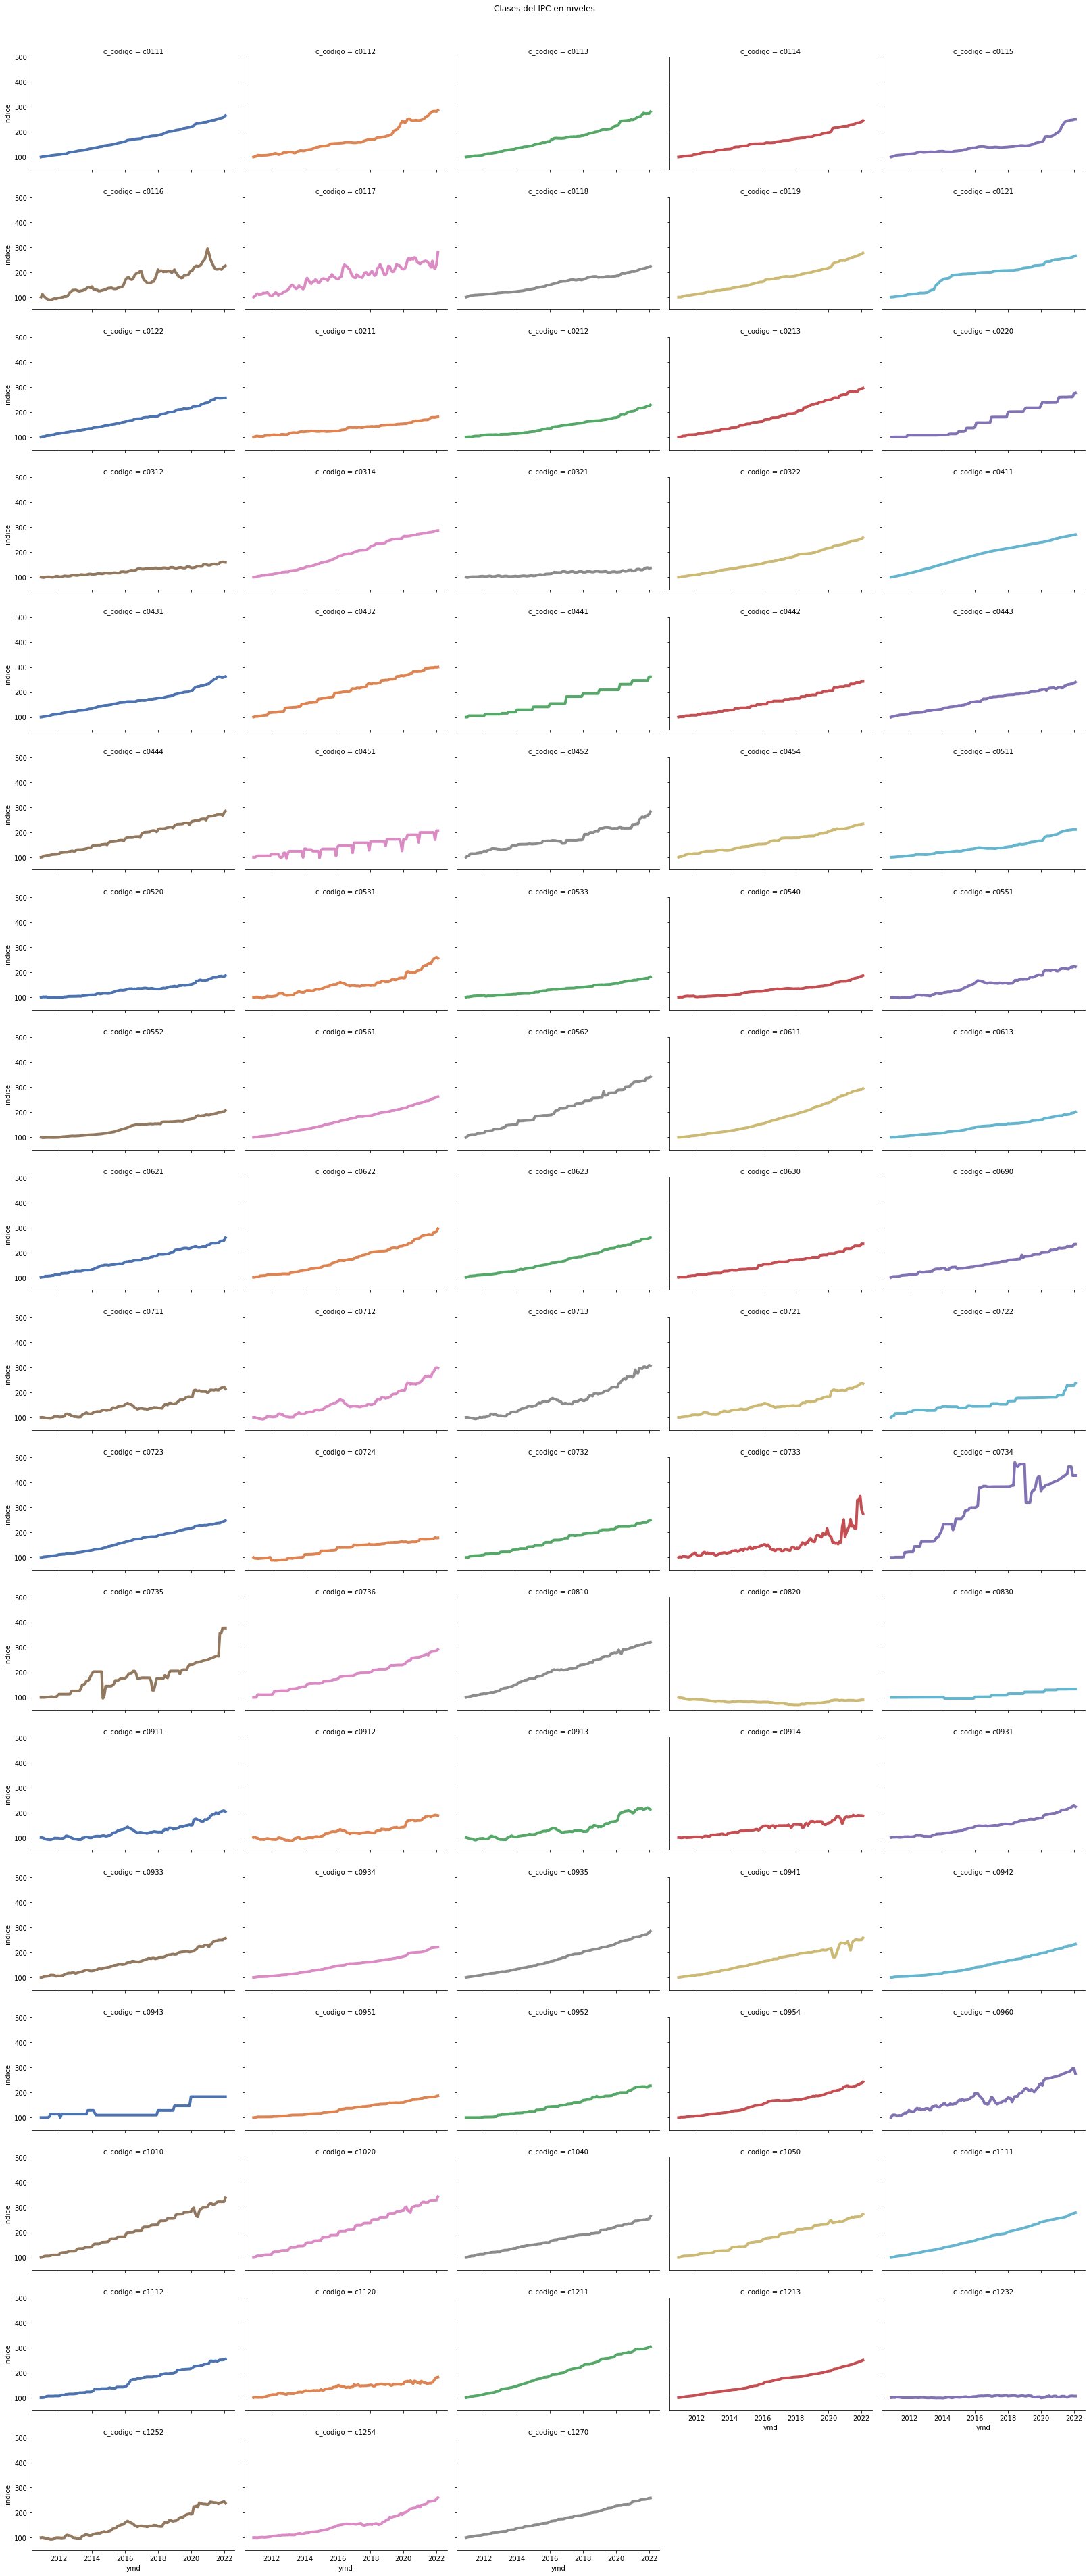

In [31]:
import seaborn as sns
g = sns.relplot(data = clases_ipc, x = "ymd", y = "indice",
                col = "c_codigo", hue = "c_codigo",
                kind = "line", palette = "deep",   
                linewidth = 4, zorder = 5,
                col_wrap = 5, height = 3, aspect = 1.5, legend = False
               )
g.fig.subplots_adjust(top=0.96)
g.fig.suptitle('Clases del IPC en niveles')

### Logaritmos y normalización de las clases del IPC

In [32]:
# Se transforman las series a logaritmos.
ipc_wide_log = np.log(ipc_wide)
print('ipc_wide_log', "dataframe con las clases del IPC en logaritmos", sep=', ')

ipc_wide_log, dataframe con las clases del IPC en logaritmos


In [33]:
import plotly.express as px
fig = px.line(ipc_wide_log.reset_index(), x='ymd', y=componentes, title='Clases del IPC en logaritmos')
fig.show()

In [48]:
# minmax
scaler = MinMaxScaler(feature_range=(0, 1))
scaler=scaler.fit(ipc_wide_log)
#normalized=scaler.transform(alim)
ipc_wide_log[:] = scaler.fit_transform(ipc_wide_log)

In [49]:
import plotly.express as px
fig = px.line(ipc_wide_log.reset_index(), x='ymd', y=componentes, title='Clases del IPC en logaritmos y normalizadas')
fig.show()

#### Estudio de las tendencias, ciclos y estacionariedad de las series del IPC

##### Pruebas de raíces unitarias y de estacionariedad

###### Pruebas ADF

In [276]:
ipc=ipc_wide_log.copy()

In [272]:
from statsmodels.tsa.stattools import adfuller
# Modelo (c) con constante y con tendencia
def adfuller_test_ct(series, signif=0.05):
  """
  Augmented Dickey-Fuller unit root test.
  The Augmented Dickey-Fuller test can be used to test for a unit root in 
  a univariate process in the presence of serial correlation.
  series: time series in pd.Series format
  signif: significance level for P-value to reject Null Hypothesis
  Null Hypothesis: The series has a unit root.
  Alternate Hypothesis: The series has no unit root.
  If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary
  If True then No RH_0), else RH_0)
  """
  x = adfuller(series, autolag='AIC',  store=True, regresults=True, regression='ct', maxlag=None)# constant and trend
  #output = {'The test statistic': x[0],'p-value': x[1],  'critical values': x[2], f'Reject (signif. level {signif})': 'Stationary' if x[1] < signif else 'Not Stationary' }
  results= {'Rh0':True if x[1] < signif else False} 
  return pd.Series(results)

In [277]:
adf_log_ipc=ipc.apply(lambda x: adfuller_test_ct(x), axis=0).T

In [278]:
len(adf_log_ipc[adf_log_ipc['Rh0']==True])

,Rh0
c_codigo,
c0116,True
c0322,True
c0630,True
c0914,True
c0942,True
c0952,True


In [301]:
from statsmodels.tsa.stattools import kpss
def kpss_trend_auto(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a trend
  nlags: Indicates the number of lags to be used. 
  nlags=“legacy”, uses int(12 * (n / 100)**(1 / 4)), as outlined in Schwert (1989)
  with “auto” lags are calculated using the data-dependent method of Hobijn et al.(1998)

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
  x = kpss(series, nlags='auto', regression='ct') # “ct” : The data is stationary around a trend.

    #using dictionary saves different data types (float, int, boolean)
  output = {'kpss_stat': x[0], 'P-value': x[1], 'lags': x[2], 'Rh0':True if x[1] < signif else False }
  #results= {'Rh0':True if x[1] < signif else False} 
  return pd.Series(output)

In [303]:
kpss_log_ipc=ipc.apply(lambda x: kpss_trend_auto(x), axis=0).T
len(kpss_log_ipc[kpss_log_ipc['Rh0']==False])

14

In [305]:
kpss_log_ipc[kpss_log_ipc['Rh0']==False]

,kpss_stat,P-value,lags,Rh0
c_codigo,,,,
c0116,0.109677,0.1,6,False
c0211,0.139097,0.062783,6,False
c0213,0.106708,0.1,5,False
c0321,0.142115,0.057195,6,False
c0322,0.136441,0.067701,6,False
c0451,0.03274,0.1,2,False
c0452,0.124331,0.090127,6,False
c0551,0.128506,0.082397,6,False
c0613,0.144993,0.051866,6,False


In [298]:
from statsmodels.tsa.stattools import kpss
def kpss_trend_lshort(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a trend
  nlags: Indicates the number of lags to be used. 
  nlags= lshort is int(4*(len(series)/100)**0.25) from R documentation related to kpss

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
  lshort=int(0.25*(len(series)/100)**0.25)  
  x = kpss(series, nlags=lshort, regression='ct') # “ct” : The data is stationary around a trend.

    #using dictionary saves different data types (float, int, boolean)
  #output = {'kpss_stat': x[0], 'P-value': x[1], 'lags': x[2], f'Reject (signif. level {signif})': x[1] < signif }
  results= {'Rh0':True if x[1] < signif else False} 
  return pd.Series(results)

In [299]:
kpss_log_ipc_ls=ipc.apply(lambda x: kpss_trend_lshort(x), axis=0).T
len(kpss_log_ipc_ls[kpss_log_ipc_ls['Rh0']==False])

1

In [300]:
kpss_log_ipc_ls[kpss_log_ipc_ls['Rh0']==False]

,Rh0
c_codigo,
c0451,False


In [287]:
from statsmodels.tsa.stattools import kpss
def kpss_trend_legacy(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a trend
  nlags: Indicates the number of lags to be used. 
  nlags=“legacy”, uses int(12 * (n / 100)**(1 / 4)), as outlined in Schwert (1989)
  with “auto” lags are calculated using the data-dependent method of Hobijn et al.(1998)

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
   
  x = kpss(series, nlags='legacy', regression='ct') # “ct” : The data is stationary around a trend.

    #using dictionary saves different data types (float, int, boolean)
  results= {'Rh0':True if x[1] < signif else False}
  return pd.Series(results)

In [289]:
kpss_log_ipc_l=ipc.apply(lambda x: kpss_trend_legacy(x), axis=0).T
len(kpss_log_ipc_l[kpss_log_ipc_l['Rh0']==False])

47

In [118]:
T=len(ipc)
r_ct=3

#### Calculo $Φ_2$:

$H_0)\:a_0=a=2=γ=0$

In [151]:
results_as_html = reg_res_c.summary().tables[1].as_html()
tau_t=pd.read_html(results_as_html, header=0, index_col=0)[0]
'Rh_0) gamma=0' if tau_t.iloc[0,3]<= 0.05 else 'No Rh_0) gamma=0 -> RU

SyntaxError: ignored

In [162]:
# Modelo (c) con constante y con tendencia
def adfuller_test_ct(series, signif=0.05):
  r_c=3
  T=len(ipc)
  adf_c = ADF(series, trend="ct", method='aic')
  reg_res_c = adf_c.regression
  ssr_c=reg_res_c.ssr
  k_c=adf_c.regression.model.df_model + 1
  gd_c=T-k_c
  adf_a = ADF(ipc.iloc[:,0], trend="n", method='aic')
  ssr_a = adf_a.regression.ssr
  ##
  phi_2=((ssr_a-ssr_c)/r_c)/(ssr_c/gd_c)

  #output = {'The test statistic': x[0],'p-value': x[1],  'critical values': x[2], f'Reject (signif. level {signif})': 'Stationary' if x[1] < signif else 'Not Stationary' }
  #results={f'TS': 'Stationary' if x[1] < signif else 'Not Stationary' } 
  return pd.Series(phi_2)

In [163]:
def adfuller_test_ct(series, signif=0.05):
  adf_c = ADF(series, trend="ct", method='aic')


ValueError: ignored

In [215]:
ipc.iloc[:,0]

ymd
2010-12-01    0.000000
2011-01-01    0.012105
2011-02-01    0.015941
2011-03-01    0.021667
2011-04-01    0.031042
                ...   
2021-10-01    0.957338
2021-11-01    0.961145
2021-12-01    0.968479
2022-01-01    0.985690
2022-02-01    1.000000
Name: c0111, Length: 135, dtype: float64

In [214]:
type(ipc.iloc[:,0])

pandas.core.series.Series

In [260]:
def ru_modelo_c(series):
  adf= ADF(series, trend="ct", method='aic')
  reg= adf.regression
  results_as_html = reg.summary().tables[1].as_html()
  tau_t=pd.read_html(results_as_html, header=0, index_col=0)[0]
  #result='Rh_0) gamma=0' if tau_t.iloc[0,3]<= signif else 'No Rh_0) gamma=0 -> RU'
  est=tau_t.iloc[0,1]/tau_t.iloc[0,2]
  result=True if est<= -3.45 else False
  return est

In [262]:
ru_modelo_c(ipc.iloc[:,0])

-0.013698630136986302

In [244]:
gamma0=pd.DataFrame(ipc.apply(ru_modelo_c, axis=0), columns=["GamaIgualcero"])
gamma0.head()

,GamaIgualcero
c_codigo,
c0111,False
c0112,False
c0113,False
c0114,False
c0115,False


In [245]:
print(f'Cantidad con gamma distinto de cero: {gamma0[gamma0["GamaIgualcero"]==True].shape[0]}, Cantidad con gamma cero: {gamma0[gamma0["GamaIgualcero"]==False].shape[0]}')

Cantidad con gamma distinto de cero: 0, Cantidad con gamma cero: 88


In [191]:
ru_modelo_c(ipc.iloc[:,0])

False


In [185]:
# c contra a
def c_contra_a(series):
  r_c=3
  T=len(ipc)
  adf_c = ADF(series, trend="ct", method='aic')
  reg_res_c = adf_c.regression
  ssr_c=reg_res_c.ssr
  k_c=adf_c.regression.model.df_model + 1
  gd_c=T-k_c
  adf_a = ADF(ipc.iloc[:,0], trend="n", method='aic')
  ssr_a = adf_a.regression.ssr
  ##
  phi_2=((ssr_a-ssr_c)/r_c)/(ssr_c/gd_c)
  print('Rh_0) a0=a2=gamma=0 -> one or more param is does not equal zero' if phi_2>=4.88 else 'No Rh_0) a0=a2=gamma=0 -> all equal zero')

In [186]:
c_contra_a(ipc.iloc[:,0])

Rh_0) a0=a2=gamma=0 -> one or more param is does not equal zero


In [183]:
# c contra b ValueError
def c_contra_b(series):
  r_c=3
  T=len(ipc)
  adf_c = ADF(series, trend="ct", method='aic')
  reg_res_c = adf_c.regression
  ssr_c=reg_res_c.ssr
  k_c=adf_c.regression.model.df_model + 1
  gd_c=T-k_c

  adf_b = ADF(ipc.iloc[:,0], trend="c", method='aic')
  ssr_b = adf_b.regression.ssr
  ##
  phi_3=((ssr_b-ssr_c)/r_c)/(ssr_c/gd_c)
  return print ('Rh_0) a2=gamma=0 -> TS' if phi_3>=6.49 else 'No Rh_0) a2=gamma=0 -> RU or deterministic trend')

In [184]:
c_contra_b(ipc.iloc[:,0])

No Rh_0) a2=gamma=0 -> RU or deterministic trend


In [157]:
results_as_html = reg_res_c.summary().tables[1].as_html()
tau_t=pd.read_html(results_as_html, header=0, index_col=0)[0]
'Rh_0) gamma=0' if tau_t.iloc[0,3]<= 0.05 else 'No Rh_0) gamma=0 -> RU'

'No Rh_0) gamma=0 -> RU'

In [158]:
print(reg_res_c.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     7.935
Date:                Sat, 18 Mar 2023   Prob (F-statistic):           1.61e-06
Time:                        23:15:40   Log-Likelihood:                 533.69
No. Observations:                 131   AIC:                            -1055.
Df Residuals:                     125   BIC:                            -1038.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0449      0.025     -1.825      0.0

In [159]:
# restricted model
adf_ct = ADF(ipc.iloc[:,0], trend="ct", method='aic')
reg_res_ct = adf_ct.regression
ssr_ur=reg_res_ct.ssr
r=3
regression.model.df_model

NameError: ignored

In [ ]:
# restricted
adf_n = ADF(ipc.iloc[:,0], trend="n", method='aic')
reg_res_n = adf_n.regression
SRR_r_ct = (reg_res_ct.resid.sum())**2

In [ ]:
reg_res_ct.ssr, reg_res_ct.nobs, adf.lags

In [ ]:
adf.regression.model.df_model

In [ ]:
RegressionResults(reg_res_ct.df_model)

In [ ]:
reg_res_nc.summary().as_html()


In [ ]:
results_as_html = reg_res_nc.summary().tables[1].as_html()
len(pd.read_html(results_as_html, header=0, index_col=0)[0])

In [ ]:
type(reg_res_nc.summary().tables[1])

In [ ]:
#unrestricted
adf_nc = ADF(ipc.iloc[:,0],trend="nc",  method='aic')
reg_res_nc = adf_nc.regression
print(reg_res_nc.summary().as_text())

In [ ]:
reg_res.summary()

In [ ]:
adf = ADF(ipc.iloc[:,0], trend="ct", method='aic')
reg_res = adf.regression
adf.lags, adf.nobs


In [ ]:
reg_res.resid

In [ ]:
adf = ADF(ipc.iloc[:,0], trend="ct", method='aic')
reg_res = adf.regression
print(reg_res.summary().as_text())

In [ ]:
from arch.unitroot import ADF
def adfuller_ct(series, signif=0.05):
  adf = ADF(series, trend="ct", method='aic')
  reg_res = adf.regression

In [ ]:
reg_res.summary()

In [ ]:
from statsmodels.tsa.stattools import adfuller
# Modelo (c) con constante y con tendencia
def adfuller_test_ct(series, signif=0.05):
  """
  Augmented Dickey-Fuller unit root test.
  The Augmented Dickey-Fuller test can be used to test for a unit root in 
  a univariate process in the presence of serial correlation.
  series: time series in pd.Series format
  signif: significance level for P-value to reject Null Hypothesis
  Null Hypothesis: The series has a unit root.
  Alternate Hypothesis: The series has no unit root.
  If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary
  If True then No RH_0), else RH_0)
  """
  x = adfuller(series, autolag='AIC',  store=True, regresults=True, regression='ct', maxlag=None)# constant and trend
  #output = {'The test statistic': x[0],'p-value': x[1],  'critical values': x[2], f'Reject (signif. level {signif})': 'Stationary' if x[1] < signif else 'Not Stationary' }
  results={f'TS': 'Stationary' if x[1] < signif else 'Not Stationary' } 
  return pd.Series(results)

In [ ]:
adf_log_ct=ipc_wide_log.apply(lambda x: adfuller_test_ct(x), axis=0).T

In [ ]:
print(f' Series estacionarias: {adf_log_ct[adf_log_ct["TS"]=="Stationary"].index.tolist()}')

In [ ]:
print(f'Cantidad de series en logaritmos Estacionarias en modelo (c): {adf_log_ct[adf_log_ct["TS"]=="Stationary"].shape[0]}')

In [ ]:
print(f' Series No estacionarias: {adf_log_ct[adf_log_ct["TS"]=="Not Stationary"].index.tolist()}')

In [ ]:
print(f'Cantidad de series en logaritmos No estacionarias en modelo (c): {adf_log_ct[adf_log_ct["TS"]=="Not Stationary"].shape[0]}')

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test_c(series, signif=0.05):
  """
  Augmented Dickey-Fuller unit root test.
  The Augmented Dickey-Fuller test can be used to test for a unit root in 
  a univariate process in the presence of serial correlation.
  

  series: time series in pd.Series format
  signif: significance level for P-value to reject Null Hypothesis
  Null Hypothesis: The series has a unit root.
  Alternate Hypothesis: The series has no unit root.
  If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary
  If True then No RH_0), else RH_0)
  """
    
  x = adfuller(series, autolag='AIC',  store=True, regresults=True, regression='c', maxlag=None)# constant only

    #using dictionary saves different data types (float, int, boolean)
  output = {'The test statistic': x[0],
      'p-value': x[1], 
              'critical values': x[2], 
              f'Reject (signif. level {signif})': x[1] < signif
            }


  return pd.Series(output)

In [ ]:
# testeo las 82 series no estacionarias del modelo (c)
adf_log_c=ipc_wide_log.loc[:,ls_adf_log_ct_f].apply(lambda x: adfuller_test_c(x), axis=0)
adf_log_c

In [ ]:
adf_log_c_f=(adf_log_c[adf_log_c.columns[adf_log_c.iloc[3]==False]])
ls_adf_log_c_f=adf_log_c_f.columns.tolist()
print(f'Cantidad de series en logaritmos no estacionarias en modelo (b):  {len(ls_adf_log_c_f)} en total')

In [ ]:
adf_log_c_t=(adf_log_c[adf_log_c.columns[adf_log_c.iloc[3]==True]])
ls_adf_log_c_t=adf_log_c_t.columns.tolist()
print(f'Cantidad de series en logaritmos estacionarias en modelo (b):  {len(ls_adf_log_c_t)} en total')

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test_n(series, signif=0.05):
  """
  Null Hypothesis: Data has unit root and is non-stationary.

  series: time series in pd.Series format
  signif: significance level for P-value to reject Null Hypothesis
  """
    
  x = adfuller(series, autolag='AIC',  store=True, regresults=True, regression='nc')

    #using dictionary saves different data types (float, int, boolean)
  output = {
      'Test Statistic': x[0], 
              'P-value': x[1], 
              'Critical values': x[2], 
              f'Reject (signif. level {signif})': x[1] < signif }


  return pd.Series(output)

In [ ]:
adf_log_n=ipc_wide_log.loc[:,ls_adf_log_c_f].apply(lambda x: adfuller_test_n(x), axis=0)

In [ ]:
adf_n_log=(adf_log_n[adf_log_n.columns[adf_log_n.iloc[3]==False]])
ls_adf_n_log=adf_n_log.columns.tolist()
print(f'Cantidad de series en logaritmos no estacionarias en modelo (a):  {len(ls_adf_n_log)} en total')

In [ ]:
print(f'Series en logaritmos no estacionarias según test de Dickey-Füller:  {ls_adf_n_log}')

In [ ]:
ls_adf_est=set(ls_adf_log_ct_t + ls_adf_log_c_t)
print(f'Series en logaritmos estacionarias según test de Dickey-Füller:  {ls_adf_est}')

In [ ]:
# cantidad de series estacionarias según tests de adf:
print(f'Series en logaritmos estacionarias según test de Dickey-Füller:  {len(ls_adf_est)}')

###### Pruebas KPSS

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_trend_legacy(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a trend
  nlags: Indicates the number of lags to be used. 
  nlags=“legacy”, uses int(12 * (n / 100)**(1 / 4)), as outlined in Schwert (1989)
  with “auto” lags are calculated using the data-dependent method of Hobijn et al.(1998)

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
   
  x = kpss(series, nlags='legacy', regression='ct') # “ct” : The data is stationary around a trend.

    #using dictionary saves different data types (float, int, boolean)
  output = {
      'kpss_stat': x[0], 
              'P-value': x[1], 
              'lags': x[2], 
              f'Reject (signif. level {signif})': x[1] < signif }


  return pd.Series(output)

In [ ]:
kpss_log_l_t=ipc_wide_log.apply(lambda x: kpss_trend_legacy(x), axis=0)
kpss_log_l_t.T.head(3)

In [ ]:
kpss_log_tr=(kpss_log_l_t[kpss_log_l_t.columns[kpss_log_l_t.iloc[3]==True]])
ls_kpss_log_l_t=kpss_log_l_t.columns.tolist()
print(f'Cantidad de series en logaritmos no estacionarias alrededor de una tendencia con nlags=legacy:  {len(ls_kpss_log_l_t)} en total')

Siguiendo la documentación del paquete de [statmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html) en python, se pueden presentar los siguientes casos:

* Caso 1: Ambos test arrojan como conclusión de que la series es no estacionarias, entonces la series es no estacionaria. 


* Caso 2: Ambos test concluyen que las series son estacionarias, entonces son estacionarias.


* Caso 3: KPSS indica estacionariedad y ADF no estacioanriedad, entonces la serie es estacionaria alrededor de una tendencia. Se necesita remover la tendencia para que la serie sea estrictamente estacionaria y se vuelve a testear la estacionariedad de la misma. 


* Caso 4: KPSS indica no estacionariedad pero ADF indica estacionariedad. La serie entonces es estacionaria en diferencias. Para obtener una serie estacionaria es necesario diferenciarla. Luego se testea la estacionariedad sobre la serie diferenciada.


Dado que de los resultados de las pruebas, las 88 series normalizadas y en logaritmos serían no estacionarias alrededor de una tendencia. Para 6 series,la prueba de ADF para un modelo (c) indica que son estacionarias pero al contradecirse este resultado con los de una prueba KPSS, sería necesario diferenciar a las series para volver a evaluar su estacionariedad.

### Remoción del componente de tendencia: primeras diferencias

In [ ]:
d_comp= ipc_wide_log.apply(lambda x : x.diff().dropna())

#### Ajuste estacional

In [ ]:
def STL_seasonal_adjusted(series):
  """
  1- Uses a STL method: Seasonal-Trend Decomposition Procedure Based on Loess
  * It handles any type of seasonality
  * The user can control the rate of change of the seasonal component
  * It is robust to outliers
  The seasonal argument is set to 7 by default. The larger is the integer, the more ‘smooth’ 
  the seasonal component becomes. This causes less of the variation in the data to be attributed to its seasonal component.
  2- Keeps only the seasonal component (sc) and creates a df with the sc of each IPC component
  3- Removes from original series the seasonal component
  """
  x  = STL(series, robust = False).fit()
  output =  series-x.seasonal
  return pd.Series(output)

In [ ]:
stl_d_comp=d_comp.apply(lambda x: STL_seasonal_adjusted(x))

In [ ]:
import plotly.express as px
fig = px.line(stl_d_comp.reset_index(), x='ymd', y=componentes, title='Clases del IPC en primeras diferencias ajustadas por estacionalidad')
fig.show()

In [ ]:
cod_lt=list(stl_d_comp.reset_index().iloc[:, 1:].columns)
d1_comp_long= pd.melt(stl_d_comp.reset_index(), id_vars=['ymd'], value_vars=cod_lt)
d1_comp_long=d1_comp_long.rename({'variable': 'componente', 'value': 'indice'}, axis=1)
d1_comp_long.head(2)

In [ ]:
import seaborn as sns
g = sns.relplot(data = d1_comp_long, x = "ymd", y = "indice",
                col = "c_codigo", hue = "c_codigo",
                kind = "line", palette = "deep",   
                linewidth = 4, zorder = 5,
                col_wrap = 5, height = 3, aspect = 1.5, legend = False
               )
g.fig.subplots_adjust(top=0.96)
g.fig.suptitle('Clases del IPC primeras diferencias')

###### Pruebas ADF 

In [ ]:
# modelo (c): si true then estacionaria, False then no estacionaria
adf_1d_c= stl_d_comp.apply(lambda x: adfuller_test_ct(x), axis=0)
adf_1d_c.T.head(2)

In [ ]:
adf_d_comp_c_t=(adf_1d_c[adf_1d_c.columns[adf_1d_c.iloc[3]==True]]) # estacioanria
ls_adf_c_t=adf_d_comp_c_t.columns.tolist()
print(f'Cantidad de series en 1ras diferencias ESTACIONARIAS en modelo (c):  {len(ls_adf_c_t)} en total')

In [ ]:
adf_d_comp_ct_f=(adf_1d_c[adf_1d_c.columns[adf_1d_c.iloc[3]==False]])
ls_adf_c_f=adf_d_comp_ct_f.columns.tolist() # series NO estacionarias
print(f'Cantidad de series en 1ras diferencias NO estacionarias en modelo (c):  {len(ls_adf_c_f)} en total')

In [ ]:
# modelo (b)
adf_d_comp_b=stl_d_comp.loc[:,ls_adf_c_f].apply(lambda x: adfuller_test_c(x), axis=0)

In [ ]:
adf_d_comp_b_t=(adf_d_comp_b[adf_d_comp_b.columns[adf_d_comp_b.iloc[3]==True]])# est
ls_adf_d_comp_b_t=adf_d_comp_b_t.columns.tolist()
print(f'Cantidad de series en 1ras diferencias ESTACIONARIAS en modelo (b): {len(ls_adf_d_comp_b_t)} sobre {len(ls_adf_c_f)} no estacionarias en modelo (c)')

In [ ]:
adf_d_comp_b_f=(adf_d_comp_b[adf_d_comp_b.columns[adf_d_comp_b.iloc[3]==False]])
ls_adf_d_comp_b_f=adf_d_comp_b_f.columns.tolist()
print(f'Cantidad de series en 1ras diferencias NO estacionarias en modelo (b):  {len(ls_adf_d_comp_b_f)} sobre {len(ls_adf_c_f)} no estacionarias en modelo (c)')

In [ ]:
# modelo (a)
adf_d_comp_a=stl_d_comp.loc[:,ls_adf_d_comp_b_f].apply(lambda x: adfuller_test_n(x), axis=0)

In [ ]:
adf_d_comp_a_t=(adf_d_comp_a[adf_d_comp_a.columns[adf_d_comp_a.iloc[3]==True]])# est
ls_adf_d_comp_a_t=adf_d_comp_a_t.columns.tolist()
print(f'Cantidad de series en 1ras diferencias ESTACIONARIAS  en modelo (a):  {len(ls_adf_d_comp_a_t)} sobre {len(ls_adf_d_comp_b_f)} no estacionarias en modelo (b)')

In [ ]:
adf_d_comp_a_f=(adf_d_comp_a[adf_d_comp_a.columns[adf_d_comp_a.iloc[3]==False]])
ls_adf_d_comp_a_f=adf_d_comp_a_f.columns.tolist()
print(f'Cantidad de series en 1ras diferencias NO estacionarias en modelo (a): {len(ls_adf_d_comp_a_f)} sobre {len(ls_adf_d_comp_b_f)} no estacionarias en modelo (b)')

In [ ]:
print(f'En total, cantidad de series ESTACIONARIAS en ADF: {len(ls_adf_d_comp_a_t+ ls_adf_d_comp_b_t+ls_adf_c_t)} ')

In [ ]:
lt_estacionarias_adf=ls_adf_d_comp_a_t+ ls_adf_d_comp_b_t+ls_adf_c_t

In [ ]:
print(f'En total, cantidad de series NO estacionarias en ADF: {len(ls_adf_d_comp_a_f)} ')

In [ ]:
lt_no_estacionarias_adf=ls_adf_d_comp_a_f

###### Pruebas KPSS

In [ ]:
# ls_est_adf=ls_adf_d_comp_a_t+ ls_adf_d_comp_b_t+ls_adf_c_t
kpss_est_adf_trend_l=stl_d_comp.apply(lambda x: kpss_trend_legacy(x), axis=0)
kpss_est_adf_trend_l.T.head(3)

In [ ]:
print(f'Cantidad nlags: {kpss_est_adf_trend_l.T.iloc[:,2].mean()}')

In [ ]:
kpss_est_adf_trend_l_t=(kpss_est_adf_trend_l[kpss_est_adf_trend_l.columns[kpss_est_adf_trend_l.iloc[3]==True]])# no esta
ls_kpss_est_adf_trend_l_t=kpss_est_adf_trend_l_t.columns.tolist()
print(f'Cantidad de series en 1ras diferencias no estacioanrias alrededor de una tendencia con nlags=legacy: {len(ls_kpss_est_adf_trend_l_t)}')

In [ ]:
i_12=ls_kpss_est_adf_trend_l_t

In [ ]:
kpss_est_adf_trend_l_f=(kpss_est_adf_trend_l[kpss_est_adf_trend_l.columns[kpss_est_adf_trend_l.iloc[3]==False]])# est
ls_kpss_est_adf_trend_l_f=kpss_est_adf_trend_l_f.columns.tolist()
print(f'Cantidad de series en 1ras diferencias estacionarias alrededor de una tendencia con nlags=legacy:  {len(ls_kpss_est_adf_trend_l_f)}')

In [ ]:
i_11=ls_kpss_est_adf_trend_l_f


In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_trend_lshort(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a trend
  nlags: Indicates the number of lags to be used. 
  nlags= lshort is int(4*(len(series)/100)**0.25) from R documentation related to kpss

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
  lshort=int(4*(len(series)/100)**0.25)  
  x = kpss(series, nlags=lshort, regression='ct') # “ct” : The data is stationary around a trend.

    #using dictionary saves different data types (float, int, boolean)
  output = {
      'kpss_stat': x[0], 
              'P-value': x[1], 
              'lags': x[2], 
              f'Reject (signif. level {signif})': x[1] < signif,
            
             }


  return pd.Series(output)

In [ ]:
kpss_est_adf_trend_ls=stl_d_comp.apply(lambda x: kpss_trend_lshort(x), axis=0)

In [ ]:
kpss_est_adf_trend_ls_t=(kpss_est_adf_trend_ls[kpss_est_adf_trend_ls.columns[kpss_est_adf_trend_ls.iloc[3]==True]])# no esta
ls_kpss_est_adf_trend_ls_t=kpss_est_adf_trend_ls_t.columns.tolist()
print(f'Cantidad de series en 1ras diferencias NO estacioanrias alrededor de una tendencia con nlags=lshort: {len(ls_kpss_est_adf_trend_ls_t)}')

In [ ]:
i_22=ls_kpss_est_adf_trend_ls_t

In [ ]:
kpss_est_adf_trend_ls_f=(kpss_est_adf_trend_ls[kpss_est_adf_trend_ls.columns[kpss_est_adf_trend_ls.iloc[3]==False]])
ls_kpss_est_adf_trend_ls_f=kpss_est_adf_trend_ls_f.columns.tolist()
print(f'Cantidad de series en 1ras diferencias  ESTACIONARIAS alrededor de una tendencia con nlags=lshort: {len(ls_kpss_est_adf_trend_ls_f)}')

In [ ]:
i_21=ls_kpss_est_adf_trend_ls_f

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_trend_auto(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a trend
  nlags: Indicates the number of lags to be used. 
  nlags=“legacy”, uses int(12 * (n / 100)**(1 / 4)), as outlined in Schwert (1989)
  with “auto” lags are calculated using the data-dependent method of Hobijn et al.(1998)

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
    
  x = kpss(series, nlags='auto', regression='ct') # “ct” : The data is stationary around a trend.

    #using dictionary saves different data types (float, int, boolean)
  output = {
      'kpss_stat': x[0], 
              'P-value': x[1], 
              'lags': x[2], 
              f'Reject (signif. level {signif})': x[1] < signif }


  return pd.Series(output)

In [ ]:
kpss_d_comp_trend_a=stl_d_comp.apply(lambda x: kpss_trend_auto(x), axis=0)
kpss_d_comp_trend_a.T.head(3)

In [ ]:
print(f'Maximo nlags: {kpss_d_comp_trend_a.T.iloc[:,2].max()}, Minimo nlags: {kpss_d_comp_trend_a.T.iloc[:,2].min()} ')

In [ ]:
kpss_d_comp_trend_a_t=(kpss_d_comp_trend_a[kpss_d_comp_trend_a.columns[kpss_d_comp_trend_a.iloc[3]==True]])# no esta
ls_kpss_d_comp_trend_a_t=kpss_d_comp_trend_a_t.columns.tolist()
print(f'Cantidad de series en 1ras diferencias NO estacioanrias alrededor de una tendencia con nlags=auto: {len(ls_kpss_d_comp_trend_a_t)}')

In [ ]:
i_32=ls_kpss_d_comp_trend_a_t

In [ ]:
kpss_d_comp_trend_a_f=(kpss_d_comp_trend_a[kpss_d_comp_trend_a.columns[kpss_d_comp_trend_a.iloc[3]==False]])# esta
ls_kpss_d_comp_trend_a_f=kpss_d_comp_trend_a_f.columns.tolist()
print(f'Cantidad de series en 1ras diferencias ESTACIONARIAS alrededor de una tendencia con nlags=auto: {len(ls_kpss_d_comp_trend_a_f)}')

In [ ]:
i_31=ls_kpss_d_comp_trend_a_f

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_constant_legacy(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a constant (default)
  nlags: Indicates the number of lags to be used. 
  nlags=“legacy”, uses int(12 * (n / 100)**(1 / 4)), as outlined in Schwert (1989)
  with “auto” lags are calculated using the data-dependent method of Hobijn et al.(1998)

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
    
  x = kpss(series, nlags='legacy', regression='c') # “ct” : The data is stationary around a constant

    #using dictionary saves different data types (float, int, boolean)
  output = {
      'kpss_stat': x[0], 
              'P-value': x[1], 
              'lags': x[2], 
              f'Reject (signif. level {signif})': x[1] < signif }


  return pd.Series(output)

In [ ]:
kpss_d_comp_l_c=stl_d_comp.apply(lambda x: kpss_constant_legacy(x), axis=0)

In [ ]:
kpss_d_comp_l_c_t=(kpss_d_comp_l_c[kpss_d_comp_l_c.columns[kpss_d_comp_l_c.iloc[3]==True]])# no esta
ls_kpss_d_comp_l_c_t=kpss_d_comp_l_c_t.columns.tolist()
print(f'Cantidad de series en 1ras diferencias NO estacioanrias alrededor de una constante: {len(ls_kpss_d_comp_l_c_t)}')

In [ ]:
j_12=ls_kpss_d_comp_l_c_t

In [ ]:
kpss_d_comp_l_c_f=(kpss_d_comp_l_c[kpss_d_comp_l_c.columns[kpss_d_comp_l_c.iloc[3]==False]])# esta
ls_kpss_d_comp_l_c_f=kpss_d_comp_l_c_f.columns.tolist()
print(f'Cantidad de series en 1ras diferencias ESTACIONARIAS alrededor de una constante: {len(ls_kpss_d_comp_l_c_f)}')

In [ ]:
j_11=ls_kpss_d_comp_l_c_f

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_constant_lshort(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a constant (default)
  nlags: Indicates the number of lags to be used. 
  nlags=“legacy”, uses int(12 * (n / 100)**(1 / 4)), as outlined in Schwert (1989)
  with “auto” lags are calculated using the data-dependent method of Hobijn et al.(1998)

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
  lshort=int(4*(len(series)/100)**0.25)   
  x = kpss(series, nlags=lshort, regression='c') # “ct” : The data is stationary around a constant

    #using dictionary saves different data types (float, int, boolean)
  output = {
      'kpss_stat': x[0], 
              'P-value': x[1], 
              'lags': x[2], 
              f'Reject (signif. level {signif})': x[1] < signif }


  return pd.Series(output)

In [ ]:
kpss_d_comp_ls_c=stl_d_comp.apply(lambda x: kpss_constant_lshort(x), axis=0)

In [ ]:
kpss_d_comp_ls_c_t=(kpss_d_comp_ls_c[kpss_d_comp_ls_c.columns[kpss_d_comp_ls_c.iloc[3]==True]])# no esta
ls_kpss_d_comp_ls_c_t=kpss_d_comp_ls_c_t.columns.tolist()
print(f'Cantidad de series en 1ras diferencias NO estacioanrias alrededor de una constante: {len(ls_kpss_d_comp_ls_c_t)}')

In [ ]:
j_22=ls_kpss_d_comp_ls_c_t

In [ ]:
kpss_d_comp_ls_c_f=(kpss_d_comp_ls_c[kpss_d_comp_ls_c.columns[kpss_d_comp_ls_c.iloc[3]==False]])# esta
ls_kpss_d_comp_ls_c_f=kpss_d_comp_ls_c_f.columns.tolist()
print(f'Cantidad de series en 1ras diferencias ESTACIONARIAS alrededor de una constante: {len(ls_kpss_d_comp_ls_c_f)}')

In [ ]:
j_21=ls_kpss_d_comp_ls_c_f

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_constant_auto(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a constant (default)
  nlags: Indicates the number of lags to be used. 
  nlags=“auto” lags are calculated using the data-dependent method of Hobijn et al.(1998)

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """  
  x = kpss(series, nlags='auto', regression='c') # “ct” : The data is stationary around a constant

    #using dictionary saves different data types (float, int, boolean)
  output = {
      'kpss_stat': x[0], 
              'P-value': x[1], 
              'lags': x[2], 
              f'Reject (signif. level {signif})': x[1] < signif }


  return pd.Series(output)

In [ ]:
kpss_d_comp_a_c=stl_d_comp.apply(lambda x: kpss_constant_auto(x), axis=0)

In [ ]:
kpss_d_comp_a_c_t=(kpss_d_comp_a_c[kpss_d_comp_a_c.columns[kpss_d_comp_a_c.iloc[3]==True]])# no esta
ls_kpss_d_comp_a_c_t=kpss_d_comp_a_c_t.columns.tolist()
print(f'Cantidad de series en 1ras diferencias NO estacioanrias alrededor de una constante: {len(ls_kpss_d_comp_a_c_t)}')

In [ ]:
j_32=ls_kpss_d_comp_a_c_t

In [ ]:
kpss_d_comp_a_c_f=(kpss_d_comp_a_c[kpss_d_comp_a_c.columns[kpss_d_comp_a_c.iloc[3]==False]])# esta
ls_kpss_d_comp_a_c_f=kpss_d_comp_a_c_f.columns.tolist()
print(f'Cantidad de series en 1ras diferencias ESTACIONARIAS alrededor de una constante: {len(ls_kpss_d_comp_a_c_f)}')

In [ ]:
j_31=ls_kpss_d_comp_a_c_f

In [ ]:
print(r'CUADRO: prueba KPSS alrededor de tend segúnlos distintos argumentos para nlags-> cantidad de series est y no est')
ls_i= [['nlags=legacy', len(i_11),len(i_12)], ['nlags=lshort', len(i_21),len(i_22)],
       ['nlags=auto', len(i_31),len(i_32)]]
r_i = pd.DataFrame(ls_i, columns =['KPSS_trend', 'EST','NO_EST'])
print(r_i)

In [ ]:
print(f'KPSS_trend nlags=legacy, series no estacionarias: {i_32}')

In [ ]:
import plotly.express as px
fig = px.line(stl_d_comp.loc[:, i_32].reset_index(), x='ymd', y=i_32, title='KPSS_trend nlags=legacy, series no estacionarias')
fig.show()

In [ ]:
print(r'CUADO: prueba KPSS alrededor de cte según los distintos argumentos para nlags-> cantidad de series est y no est')
ls_j= [['nlags=legacy', len(j_11),len(j_12)], ['nlags=lshort', len(j_21),len(j_22)],
       ['nlags=auto', len(j_31),len(j_32)]]
r_j = pd.DataFrame(ls_j, columns =['KPSS_constant', 'EST','NO_EST'])
print(r_j)

In [ ]:
print('Leer -> Selection of the lags-> p 206 Walter Elders')

In [ ]:
# componentes del IPC que son I(1)
I_1_comp=stl_d_comp.loc[:, j_21]

In [ ]:
len(lt_estacionarias_adf), len(lt_no_estacionarias_adf)

In [ ]:
common_list_no_est = set(j_22).intersection(lt_no_estacionarias_adf)
len(common_list_no_est)

In [ ]:
not_common_list_no_est=set(j_22) ^ set(lt_no_estacionarias_adf)
len(not_common_list_no_est)

In [ ]:
common_list_est = set(j_21).intersection(lt_estacionarias_adf)
len(common_list_est)

In [ ]:
not_common_list_est = set(j_21)^ set(lt_estacionarias_adf)
len(not_common_list_est)

### Segundas diferencias




In [ ]:
# componentes del IPC a diferenciar y probar si son I(2)
d2_comp=stl_d_comp.loc[:, j_22].apply(lambda x : x.diff().dropna())

###### Pruebas ADF

In [ ]:
d2_comp.shape

In [ ]:
# modelo (c)
adf_2d_c= d2_comp.apply(lambda x: adfuller_test_ct(x), axis=0)

In [ ]:
adf_d2_comp_c_t=(adf_2d_c[adf_2d_c.columns[adf_2d_c.iloc[3]==True]]) # estacioanria
ls_adf_d2_comp_c_t=adf_d2_comp_c_t.columns.tolist()
print(f'Cantidad de series en 2as diferencias ESTACIONARIAS en modelo (c):  {len(ls_adf_d2_comp_c_t)} en total')

In [ ]:
adf_d2_comp_c_f=(adf_2d_c[adf_2d_c.columns[adf_2d_c.iloc[3]==False]])
ls_adf_d2_comp_c_f=adf_d2_comp_c_f.columns.tolist() # series NO estacionarias
print(f'Cantidad de series en 1ras diferencias NO estacionarias en modelo (c):  {len(ls_adf_d2_comp_c_f)} en total')

In [ ]:
# modelo (b)
adf_2d_b=d2_comp.loc[:,ls_adf_d2_comp_c_f].apply(lambda x: adfuller_test_c(x), axis=0)

In [ ]:
adf_2d_b_t=(adf_2d_b[adf_2d_b.columns[adf_2d_b.iloc[3]==True]])# est
ls_adf_2d_b=adf_2d_b.columns.tolist()
print(f'Cantidad de series en 2as diferencias ESTACIONARIAS en modelo (b): {len(ls_adf_2d_b)} sobre {len(ls_adf_d2_comp_c_f)} no estacionarias en modelo (c)')

In [ ]:
# modelo (a)
adf_2d_a=d2_comp.loc[:,ls_adf_2d_b].apply(lambda x: adfuller_test_c(x), axis=0)

In [ ]:
adf_d2_comp_a_f=(adf_2d_a[adf_2d_a.columns[adf_2d_a.iloc[3]==False]])
ls_adf_2d_a_f=adf_d2_comp_a_f.columns.tolist() # series NO estacionarias
print(f'Cantidad de series en 1ras diferencias NO estacionarias en modelo (a):  {len(ls_adf_2d_a_f)}')

In [ ]:
adf_2d_b_t=(adf_2d_b[adf_2d_b.columns[adf_2d_b.iloc[3]==True]])# est
ls_adf_2d_b=adf_2d_b.columns.tolist()
print(f'Cantidad de series en 2as diferencias ESTACIONARIAS en modelo (a): {len(ls_adf_2d_b)}')

#### Pruebas KPSS

In [ ]:
# kpss constante
kpss_d2_comp_l_c=d2_comp.apply(lambda x: kpss_constant_legacy(x), axis=0)

In [ ]:
kpss_d2_comp_l_c_t=(kpss_d2_comp_l_c[kpss_d2_comp_l_c.columns[kpss_d2_comp_l_c.iloc[3]==True]])# no esta
ls_kpss_d2_comp_l_c_t=kpss_d2_comp_l_c_t.columns.tolist()
print(f'Cantidad de series en 1ras diferencias NO estacioanrias alrededor de una constante: {len(ls_kpss_d2_comp_l_c_t)}')

In [ ]:
kpss_d2_comp_l_c_f=(kpss_d2_comp_l_c[kpss_d2_comp_l_c.columns[kpss_d2_comp_l_c.iloc[3]==False]])# esta
ls_kpss_d2_comp_l_c_f=kpss_d2_comp_l_c_f.columns.tolist()
print(f'Cantidad de series en 2as diferencias ESTACIONARIAS alrededor de una constante: {len(ls_kpss_d2_comp_l_c_f)}')

In [ ]:
# series que son I(2)
I_2_comp=d2_comp

In [ ]:
(I_1_comp.shape[1]+I_2_comp.shape[1])==88

## Preprocesamiento de los datos de precios de los commodities



Se utilizan precios de tres bienes primarios y el promedio simple del precios de los alimentos y bebidas, denominados _commodities_. Los mismos son tomados de la página del Fondo Monetario Internacional, originalmente expresados en dólares.

Para el precio de la carne ($PBEEF$) se toma la serie correspondiente a la carne de Australia y Nueva Zelanda en centésimos de dólar por tonelada (Beef, Australian and New Zealand 85 % lean fores, CIF U.S. import price, US cents per pound).

Para el petróleo ($POILAPSP$) se toma el promedio de tres precios spot expresados en dólares por barril (Crude Oil (petroleum), Crude Oil (petroleum), Price index, 2016 = 100, simple average of three spot prices; Dated Brent, West Texas Intermediate, and the Dubai Fateh).

Para la soja ($PSOYB$) se toma el precio futuro de la soja en Chicago expresado en dólares por tonelada métrica (Soybeans, U.S. soybeans, Chicago Soybean futures contract (First contract forward) No. 2 yellow and par, US$ per metric ton).

Por último, para los alimentos y bebidas ($\text{avg_alim}$) se realiza un promedio de los precios de commodities alimenticios disponibles (lista cuadro Anexo). 

Los precios de commodities están disponibles desde el año 1980 hasta julio de 2022.

In [ ]:
# dataframe con todas las variables asociadas a los commodities del FMI
df_usd.shape

In [ ]:
# df con los datos en USD de todos los commodities
df_usd.tail(3)

In [ ]:
# llevo todas las columnas de precios a float
cols = df_usd.iloc[:,1:].select_dtypes(exclude=['float']).columns
df_usd[cols] = df_usd[cols].apply(pd.to_numeric, downcast='float', errors='coerce')

In [ ]:
df_usd[['year','month']]=df_usd.date.str.split('M',expand=True)
df_usd['ymd'] = pd.to_datetime(df_usd[['year', 'month']].assign(day=1), format='%d/%b/%Y')

In [ ]:
p_usd=df_usd.drop(['year', 'month','date' ], axis=1)
p_usd.head()

In [ ]:
#p_usd=p_usd.set_index('ymd')

In [ ]:
# IPC: (Timestamp('2010-12-01 00:00:00'), Timestamp('2022-02-01 00:00:00'))
p_usd.ymd.min(), p_usd.ymd.max()

In [ ]:
# acoto las series al intervalo que hoy se tiene del ipc
p_usd=p_usd[p_usd['ymd']<='2022-02-01']
p_usd=p_usd.set_index('ymd')

In [ ]:
p_usd_log = np.log(p_usd)

In [ ]:
col_p_usd_log=p_usd_log.columns

In [ ]:
p_usd_log_sin_idx=p_usd_log .reset_index()
p_usd_log_sin_idx.head()

#### Normalización de los precios externos

Se procede a normalizar los datos empleando el módulo MinMaxScaler.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler=scaler.fit(p_usd)
#normalized=scaler.transform(alim)
p_usd[:] = scaler.fit_transform(p_usd)
p_usd.head()

In [ ]:
p_usd_log = np.log(p_usd)

In [ ]:
# Las variables asociadas a los alimentos y bebidas
lista=['PBANSOP',
'PBARL',
'PBEEF',
'PCOCO',
'PCOFFOTM',
'PCOFFROB',
'PROIL',
'PFSHMEAL',
'PGNUTS',
'PLAMB',
'PMAIZMT',
'POLVOIL',
'PORANG',
'PPOIL',
'PPORK',
'PPOULT',
'PRICENPQ',
'PSALM',
'PSHRI',
'PSMEA',
'PSOIL',
'PSOYB',
'PSUGAISA',
'PSUGAUSA',
'PSUNO',
'PTEA',
'PWHEAMT', 
'PSORG',
'PTOMATO',
'PMILK', 
'PAPPLE']

In [ ]:
len(lista)

In [ ]:
# 31 elementos correspondientes a los precios de los alimentos y bebidas.
alim_log=p_usd_log[lista]
alim_log.head(2)

In [ ]:
# como tenemos valores para algunas variables iguales a cero, no se va a emplear el log para no tener valores -inf
alim=p_usd[lista]
alim.head(2)

In [ ]:
# df con el promedio simple del precio de los alimentos en USD por metric tons 
avg_fb=alim.mean(axis = 1).to_frame('avg_fb')
avg_fb.head()

In [ ]:
# ahora me quedo con un df solo con los 3 commodities de interes
lst=['PBEEF','POILAPSP','PSOYB']
ext=p_usd.filter(lst)
ext.head()

In [ ]:
# Armo df con los precios externos del modelo
pr_ext=pd.concat([ext, avg_fb], axis=1)
pr_ext.head(10)

In [ ]:
pr_ext_sin_ind=pr_ext.reset_index()

In [ ]:
pr_ext_sin_ind.columns

In [ ]:
series_exter=['PBEEF', 'POILAPSP', 'PSOYB', 'avg_fb']
fig = px.line(pr_ext_sin_ind, x='ymd', y=series_exter, title='(4) Series externas normalizadas con MinMax')
fig.show()

#### Estudio de las tendencias, ciclos y estacionariedad de los precios externos

##### Pruebas de raíces unitarias y de estacionariedad

###### Pruebas ADF

In [ ]:
adf_pr_ext_ct=pr_ext.apply(lambda x: adfuller_test_ct(x), axis=0)
adf_pr_ext_ct_f=(adf_pr_ext_ct[adf_pr_ext_ct.columns[adf_pr_ext_ct.iloc[3]==False]])
ls_adf_pr_ext_ct_f=adf_pr_ext_ct_f.columns.tolist()
print(f'Cantidad de series normalizadas no estacionarias en modelo (c):  {len(ls_adf_pr_ext_ct_f)} en total')

In [ ]:
adf_pr_ext_c=pr_ext.apply(lambda x: adfuller_test_c(x), axis=0)
adf_pr_ext_c_f=(adf_pr_ext_c[adf_pr_ext_c.columns[adf_pr_ext_c.iloc[3]==False]])
ls_adf_pr_ext_c_f=adf_pr_ext_c_f.columns.tolist()
print(f'Cantidad de series normalizadas no estacionarias en modelo (b):  {len(ls_adf_pr_ext_c_f)} en total')

In [ ]:
adf_pr_ext_n=pr_ext.apply(lambda x: adfuller_test_n(x), axis=0)
adf_pr_ext_n_f=(adf_pr_ext_n[adf_pr_ext_n.columns[adf_pr_ext_n.iloc[3]==False]])
ls_adf_pr_ext_n_f=adf_pr_ext_n_f.columns.tolist()
print(f'Cantidad de series normalizadas no estacionarias en modelo (a):  {len(ls_adf_pr_ext_n_f)} en total')

###### Pruebas KPSS

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_trend_legacy(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a trend
  nlags: Indicates the number of lags to be used. 
  nlags=“legacy”, uses int(12 * (n / 100)**(1 / 4)), as outlined in Schwert (1989)
  with “auto” lags are calculated using the data-dependent method of Hobijn et al.(1998)

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
    
  x = kpss(series, nlags='legacy', regression='ct') # “ct” : The data is stationary around a trend.

    #using dictionary saves different data types (float, int, boolean)
  output = {
      'kpss_stat': x[0], 
              'P-value': x[1], 
              'lags': x[2], 
              f'Reject (signif. level {signif})': x[1] < signif }


  return pd.Series(output)

In [ ]:
kpss_pr_ext_trend_l=pr_ext.apply(lambda x: kpss_trend_legacy(x), axis=0)

In [ ]:
kpss_pr_ext_trend_t_l=(kpss_pr_ext_trend_l[kpss_pr_ext_trend_l.columns[kpss_pr_ext_trend_l.iloc[3]==True]])# no esta
ls_kpss_pr_ext_trend_t_l=kpss_pr_ext_trend_t_l.columns.tolist()
print(f'Cantidad de series no estacioanrias alrededor de una tendencia con nlags legacy: {len(ls_kpss_pr_ext_trend_t_l)}')

In [ ]:
auto_rHO_kpss_t_l=kpss_pr_ext_trend_l.iloc[1:,:]
auto_rHO_kpss_t_l_T=auto_rHO_kpss_t_l.T
auto_rHO_kpss_t_l_T.head()

In [ ]:
auto_rHO_kpss_t_l_T['resultados'] = auto_rHO_kpss_t_l_T['Reject (signif. level 0.05)'].apply(lambda x: 'No estacionaria' if x == True else 'estacionaria')

In [ ]:
print(auto_rHO_kpss_t_l_T)

In [ ]:
Q_est_l=len(auto_rHO_kpss_t_l_T[auto_rHO_kpss_t_l_T['Reject (signif. level 0.05)']==True])
M_nlags_l=auto_rHO_kpss_t_l_T['lags'].mean()
print(f'series estacionarias con legacy:  {Q_est_l} sobre {auto_rHO_kpss_t_l_T.shape[0]} , nlags promedio: {int(M_nlags_l)}')

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_trend_auto(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a trend
  nlags: Indicates the number of lags to be used. 
  nlags=“legacy”, uses int(12 * (n / 100)**(1 / 4)), as outlined in Schwert (1989)
  with “auto” lags are calculated using the data-dependent method of Hobijn et al.(1998)

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
    
  x = kpss(series, nlags='auto', regression='ct') # “ct” : The data is stationary around a trend.

    #using dictionary saves different data types (float, int, boolean)
  output = {
      'kpss_stat': x[0], 
              'P-value': x[1], 
              'lags': x[2], 
              f'Reject (signif. level {signif})': x[1] < signif }


  return pd.Series(output)

In [ ]:
kpss_pr_ext_trend_a=pr_ext.apply(lambda x: kpss_trend_auto(x), axis=0)

In [ ]:
kpss_pr_ext_trend_t_a=(kpss_pr_ext_trend_a[kpss_pr_ext_trend_a.columns[kpss_pr_ext_trend_a.iloc[3]==True]])# no esta
ls_kpss_pr_ext_trend_t_a=kpss_pr_ext_trend_t_a.columns.tolist()
print(f'Cantidad de series no estacioanrias alrededor de una tendencia con nlags=auto: {len(ls_kpss_pr_ext_trend_t_a)}')

In [ ]:
auto_rHO_kpss_t_a=kpss_pr_ext_trend_a.iloc[1:,:]
auto_rHO_kpss_t_a_T=auto_rHO_kpss_t_a.T
auto_rHO_kpss_t_a_T.head()

In [ ]:
auto_rHO_kpss_t_a_T['resultados'] = auto_rHO_kpss_t_a_T['Reject (signif. level 0.05)'].apply(lambda x: 'No estacionaria' if x == True else 'estacionaria')

In [ ]:
Q_est_a=len(auto_rHO_kpss_t_a_T[auto_rHO_kpss_t_a_T['Reject (signif. level 0.05)']==True])
M_nlags_a=auto_rHO_kpss_t_a_T['lags'].mean()
print(f'series estacionarias con legacy:  {Q_est_a} sobre {auto_rHO_kpss_t_a_T.shape[0]} , nlags=auto promedio: {int(M_nlags_a)}')

In [ ]:
print(f'Lags de legacy son mayores a auto?  { M_nlags_l >  M_nlags_a}. Con legacy {int(M_nlags_l)}, con auto {int(M_nlags_a)}')

In [ ]:
auto_rHO_kpss_t_a_T[auto_rHO_kpss_t_a_T['Reject (signif. level 0.05)']==False]

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_trend_lshort(series, signif=0.05):
  """
  Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
  regression=“c” : The data is stationary around a trend
  nlags: Indicates the number of lags to be used. 
  nlags= lshort is int(4*(len(series)/100)**0.25) from R documentation related to kpss

  Test for the null hypothesis that x is level or trend stationary
  H_0) x is trend stationary
  H_1) x is not stationary
  If p-value < alpha then RH0) then series not stationary
  """
  lshort=int(4*(len(series)/100)**0.25)  
  x = kpss(series, nlags=lshort, regression='ct') # “ct” : The data is stationary around a trend.

    #using dictionary saves different data types (float, int, boolean)
  output = {
      'kpss_stat': x[0], 
              'P-value': x[1], 
              'lags': x[2], 
              f'Reject (signif. level {signif})': x[1] < signif,
            
             }


  return pd.Series(output)

In [ ]:
lshort=int(4*(len(pr_ext)/100)**0.25)
lshort

In [ ]:
p_value_lshort=kpss(pr_ext['PBEEF'], nlags=int(4*(len(pr_ext)/100)**0.25) , regression='ct')[1] #p-value
print(f'Es la serie PBEEF no estacioanria con nlags={lshort}? {p_value_lshort<0.05}')#p-value<alpha

### Remoción del componente de tendencia: primeras diferencias

In [ ]:
d1_ext= pr_ext.apply(lambda x : x.diff().dropna())

In [ ]:
fig = px.line(d1_ext.reset_index(), x='ymd', y=series_exter, title='(4) Series externas en 1ras diferencias')
fig.show()

##### Ajuste estacional

In [ ]:
stl_d1_ext=d1_ext.apply(lambda x: STL_seasonal_adjusted(x))

###### Pruebas ADF

In [ ]:
adf_d1_ext_ct=stl_d1_ext.apply(lambda x: adfuller_test_ct(x), axis=0)
adf_d1_ext_ct_t=(adf_d1_ext_ct[adf_d1_ext_ct.columns[adf_d1_ext_ct.iloc[3]==True]])
ls_adf_d1_ext_ct_t=adf_d1_ext_ct_t.columns.tolist()
print(f'Cantidad de series en primeras diferencias estacionarias en modelo (c):  {len(ls_adf_d1_ext_ct_t)} en total')

In [ ]:
adf_d1_ext_c=stl_d1_ext.apply(lambda x: adfuller_test_c(x), axis=0)
adf_d1_ext_c_t=(adf_d1_ext_c[adf_d1_ext_c.columns[adf_d1_ext_c.iloc[3]==True]])
ls_adf_d1_ext_c_t=adf_d1_ext_c_t.columns.tolist()
print(f'Cantidad de series en primeras diferencias estacionarias en modelo (b):  {len(ls_adf_d1_ext_c_t)} en total')

In [ ]:
adf_d1_ext_n=stl_d1_ext.apply(lambda x: adfuller_test_n(x), axis=0)
adf_d1_ext_n_t=(adf_d1_ext_n[adf_d1_ext_n.columns[adf_d1_ext_n.iloc[3]==True]])
ls_adf_d1_ext_n_t=adf_d1_ext_n_t.columns.tolist()
print(f'Cantidad de series en primeras diferencias estacionarias en modelo (a):  {len(ls_adf_d1_ext_n_t)} en total')

###### Pruebas KPSS

In [ ]:
kpss_d1_ext_ls=stl_d1_ext.apply(lambda x: kpss_trend_lshort(x), axis=0)
kpss_d1_ext_ls_f=(kpss_d1_ext_ls[kpss_d1_ext_ls.columns[kpss_d1_ext_ls.iloc[3]==False]])
ls_kpss_d1_ext_ls_f=kpss_d1_ext_ls_f.columns.tolist()
print(f'Cantidad de series en primeras diferencias estacionarias para H0) trend stationary:  {len(ls_kpss_d1_ext_ls_f)} en total')

In [ ]:
kpss_d1_ext_ls.T

In [ ]:
kpss_d1_ext_a=stl_d1_ext.apply(lambda x: kpss_trend_auto(x), axis=0)
kpss_d1_ext_a_f=(kpss_d1_ext_a[kpss_d1_ext_a.columns[kpss_d1_ext_a.iloc[3]==False]])
ls_kpss_d1_ext_a_f=kpss_d1_ext_a_f.columns.tolist()
print(f'Cantidad de series en primeras diferencias estacionarias para H0) trend stationary:  {len(ls_kpss_d1_ext_a_f)} en total')

In [ ]:
kpss_d1_ext_a.T

In [ ]:
kpss_d1_ext_l=stl_d1_ext.apply(lambda x: kpss_trend_legacy(x), axis=0)
kpss_d1_ext_l_f=(kpss_d1_ext_l[kpss_d1_ext_l.columns[kpss_d1_ext_l.iloc[3]==False]])
ls_kpss_d1_ext_l_f=kpss_d1_ext_l_f.columns.tolist()
print(f'Cantidad de series en primeras diferencias estacionarias para H0) trend stationary:  {len(ls_kpss_d1_ext_l_f)} en total')

In [ ]:
kpss_d1_ext_l.T

#### Segunda diferencia del precio promedio de los alimentos

In [ ]:
d2_avg_fb=avg_fb.diff().dropna()

In [ ]:
kpss_constant_legacy(d2_avg_fb)

In [ ]:
kpss_constant_lshort(d2_avg_fb)

In [ ]:
kpss_constant_auto(d2_avg_fb)

#### Orden de integración de las series de precios externos

# Anexo

#### Análisis de los grupos de clases del IPC

Código | Divisiones
-------------------|------------------
01       | Alimentos Y Bebidas No Alcoholicas 
02       | Bebidas Alcoholicas, Tabaco Y Estupefacientes
03       | Vestimenta Y Calzado
04       | Vivienda
05       | Muebles, Articulos Para El Hogar Y Su Conservacion
06       | Salud
07       | Transporte
08       | Comunicaciones
09       | Recreacion Y Cultura
10      | Educacion
11      | Restaurantes Y Servicios De Alojamiento
12      | Bienes Y Servicios Diversos


Cuadro 1: clases del IPC

 Código  | Clases
-------------------|------------------
0111|Pan y cereales
0112|Carne
0113|Pescado
0114|Leche, queso y huevos
0115|Aceites y grasas
0116|Frutas
0117|Legumbres y Hortalizas
0118|Azúcar, mermelada, miel, chocolate y dulces de azúcar
0119|Productos alimenticios n.e.p.
0121|Café, te y cacao
0122|Aguas minerales, refrescos, jugos de frutas y de legumbres
0211|Bebidas destiladas
0212|Vino
0213|Cerveza
0220|Tabaco
0312|Prendas de vestir
0314|Limpieza, reparación y alquiler de prendas de vestir
0321|Zapatos y otros calzados
0322|Reparación y alquiler de calzado
0411|Alquileres efectivos pagados por los inquilinos
0431|Materiales para la conservación y la reparación de la vivienda
0432|Servicios para la conservación y la reparación de la vivienda
0441|Suministro de agua
0442|Recogida de basuras
0443|Alcantarillado
0444|Otros servicios relacionados con la vivienda n.e.p.
0451|Electricidad
0452|Gas
0454|Combustibles sólidos
0511|Muebles y accesorios
0520|Productos textiles para el hogar
0531|Artefactos para el hogar grandes, eléctricos o no
0533|Reparación de artefactos para el hogar
0540|Artículos de vidrio y cristal, vajilla y utensilios para el hogar
0551|Herramientas y equipo grandes
0552|Herramientas pequeñas y accesorios diversos
0561|Bienes para el hogar no duraderos
0562|Servicios domésticos y para el hogar
0611|Productos farmacéuticos
0613|Artefactos y equipo terapéuticos
0621|Servicios médicos
0622|Servicios dentales
0623|Servicios paramédicos
0630|Servicios de hospital
0690|Servicios médicos mutuales y colectivos
0711|Vehículos a motor
0712|Motocicletas
0713|Bicicletas
0721|Piezas de repuesto y accesorios para equipo de transporte personal
0722|Combustibles y lubricantes para equipo de transporte personal
0723|Conservación y reparación de equipo de transporte personal
0724|Otros servicios relativos al equipo de transporte personal
0732|Transporte de pasajeros por carretera
0733|Transporte de pasajeros por aire
0734|Transporte de pasajeros por mar y cursos de agua interiores
0735|Transporte combinado de pasajeros
0736|Otros servicios de transporte adquiridos
0810|Servicios postales
0820|Equipo telefónico y de facsímile
0830|Servicios telefónicos y de facsímile
0911|Equipo para la recepción, grabación y reproducción de sonidos e imágenes
0912|Equipo fotográfico, cinematográfico e instrumentos ópticos
0913|Equipo de procesamiento e información
0914|Medios para grabación
0931|Juegos, juguetes y aficiones
0933|Jardines, plantas y flores
0934|Animales domésticos y productos conexos
0935|Servicios de veterinaria y de otro tipo para animales domésticos
0941|Servicios de recreación y deportivos
0942|Servicios culturales
0943|Juegos de azar
0951|Libros
0952|Diarios y periódicos
0954|Papel y útiles de oficina y materiales de dibujo
0960|Paquetes turísticos
1010|Enseñanza preescolar o enseñanza primaria
1020|Enseñanza secundaria
1040|Enseñanza terciaria
1050|Enseñanza no atribuíble a ningún nivel
1111|Restaurantes, cafés y establecimientos similares
1112|Comedores
1120|Servicios de alojamiento
1211|Salones de peluquería y establecimientos de cuidados personales
1213|Otros aparatos, articulos y productos para la atención personal
1232|Otros efectos personales
1252|Seguro relacionado con la vivienda
1254|Seguro relacionado con el transporte
1270|Otros servicios n.e.p.

# Fuentes de datos



* https://www.imf.org/en/Research/commodity-prices

* https://www.imf.org/-/media/Files/Research/CommodityPrices/TechnicalDoc.ashx

* https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781118871782.oth1